In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Using TensorFlow backend.


In [2]:
FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [14]:
import random
import shutil 

filenames = os.listdir("..\\Assignment 2\\train\\train\\")
random.shuffle(filenames)

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [7]:
df.head()

,filename,category
0,dog.9865.jpg,1
1,cat.9255.jpg,0
2,cat.4881.jpg,0
3,dog.8324.jpg,1
4,cat.5007.jpg,0


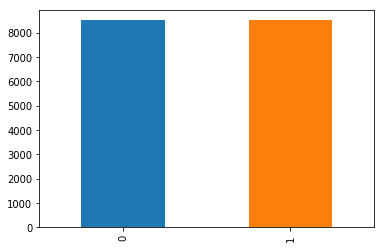

In [8]:
df['category'].value_counts().plot.bar()

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [10]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
print(total_train, total_validate)

13600 3401


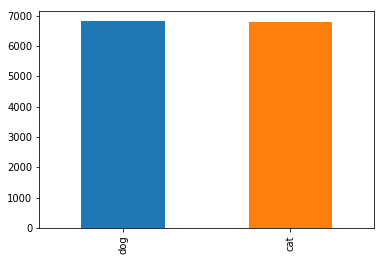

In [11]:
train_df['category'].value_counts().plot.bar()

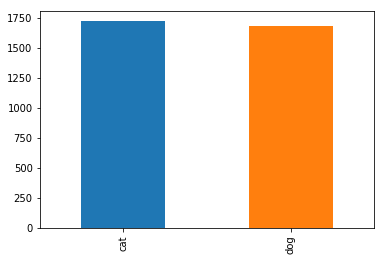

In [12]:
validate_df['category'].value_counts().plot.bar()

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "..\\Assignment 2\\train\\train\\", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 13599 validated image filenames belonging to 2 classes.


In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "..\\Assignment 2\\train\\train\\", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3401 validated image filenames belonging to 2 classes.


In [12]:
# ------------ FIT MODEL ----------- #
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
906/906 [==============================] - 930s 1s/step - loss: 0.8110 - accuracy: 0.6136 - val_loss: 0.6812 - val_accuracy: 0.6174
Epoch 2/3


C:\ProgramData\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


906/906 [==============================] - 774s 855ms/step - loss: 0.5956 - accuracy: 0.6893 - val_loss: 0.4559 - val_accuracy: 0.7164
Epoch 3/3
906/906 [==============================] - 768s 848ms/step - loss: 0.5442 - accuracy: 0.7284 - val_loss: 0.3218 - val_accuracy: 0.7055


In [17]:
# --------- Prepare test data ---------- #
test_filenames = []

for a in os.listdir("..\\Assignment 2\\train\\test\\"):
    if a.split(".")[-1] == 'jpg':
        test_filenames.append(a)
        
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "..\\Assignment 2\\train\\test\\", 
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)


Found 8000 validated image filenames.


In [17]:
# ------------- PREDICT MODEL ----------- #
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [18]:
# ---------- Convert probabilities into Classes ------------ #
test_df['category'] = np.argmax(predict,axis=-1)

In [22]:
y_pred = test_df['category']
y_pred = np.array(y_pred)
y_actual = np.array([])

for f in test_filenames:
    if f.split(".")[0].lower() == 'cat':
        y_actual = np.append(y_actual,0)
    elif f.split(".")[0].lower() == 'dog':
        y_actual = np.append(y_actual,1)

In [20]:
# --------  calculate accuracy -------- #
match = 0
total_samples = y_actual.shape[0]
for i in range(total_samples):
    if y_actual[i] == y_pred[i]:
        match += 1
print("Test Accuracy = ",match/total_samples)

Test Accuracy =  0.708
